In [10]:
!pip install --quiet gdown


file_id = "1CSkQOyYbQ0aHf67ETLJ58Gp5RlnPkSxZ"
url = f"https://drive.google.com/uc?id={file_id}"

!gdown --quiet $url -O si.lammps-dump-text

file_id = "1JCFXgqru7S-DCJIZO2Xvar87Tdgfx3qZ"
url = f"https://drive.google.com/uc?id={file_id}"

!gdown --quiet $url -O si_solid.lammps-dump-text

In [11]:
!pip install ase numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from ase.io.lammpsrun import read_lammps_dump

In [12]:
# ----------- File paths -----------
file_liquid = "si.lammps-dump-text"
file_solid  = "si_solid.lammps-dump-text"

# ----------- Parameters -----------
n_frames = 700          # last 700 frames
bin_width = 0.5         # Å
atom_type = 1           # target atom type

In [17]:
def compute_z_density(frames, bin_width, atom_type=None):
    """
    Compute average atomic number density along z (in #/nm³).

    Parameters:
        frames: list of ASE Atoms objects
        bin_width: bin width in Å
        atom_type: atom type to include (int) or None for all

    Returns:
        z_centers: bin center positions (Å)
        avg_density: average density values (#/nm³)
    """
    # Use the first frame's box to fix bin edges
    cell = frames[0].get_cell()
    z_length = cell[2, 2]
    x_len = cell[0, 0]
    y_len = cell[1, 1]

    n_bins = int(np.ceil(z_length / bin_width))
    bin_edges = np.linspace(0, z_length, n_bins + 1)

    densities_all = []

    for atoms in frames:
        if atom_type is not None:
            # If atom_type specified, filter positions (assuming 'type' array exists)
            if 'type' in atoms.arrays:
                mask = atoms.arrays['type'] == atom_type
                z_pos = atoms.positions[mask, 2]
            else:
                z_pos = atoms.positions[:, 2]
        else:
            z_pos = atoms.positions[:, 2]

        hist, _ = np.histogram(z_pos, bins=bin_edges)
        bin_volume_nm3 = (x_len * y_len * bin_width) * 1e-3  # Å³->nm³
        density = hist / bin_volume_nm3
        densities_all.append(density)

    avg_density = np.mean(densities_all, axis=0)
    z_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    return z_centers, avg_density


In [18]:
# ----------- Load last 700 frames -----------

frames_liq = read_lammps_dump(file_liquid, index=slice(-n_frames, None))
frames_sol = read_lammps_dump(file_solid, index=slice(-n_frames, None))

# ----------- Compute densities -----------

z_liq, dens_liq = compute_z_density(frames_liq, bin_width, atom_type)
z_sol, dens_sol = compute_z_density(frames_sol, bin_width, atom_type)

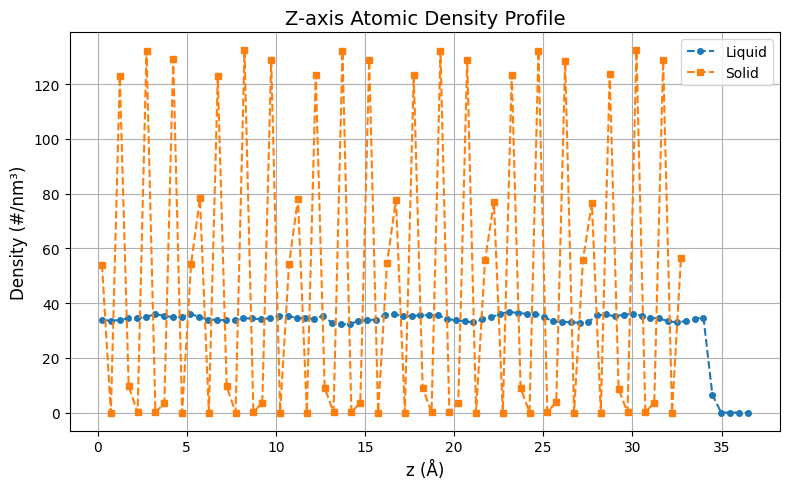

In [19]:
# ----------- Plot both densities -----------

plt.figure(figsize=(8, 5))
plt.plot(z_liq, dens_liq, label='Liquid', linestyle='--', marker='o', markersize=4)
plt.plot(z_sol, dens_sol, label='Solid', linestyle='--', marker='s', markersize=4)

plt.xlabel("z (Å)", fontsize=12)
plt.ylabel("Density (#/nm³)", fontsize=12)
plt.title("Z-axis Atomic Density Profile", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("z_density_liquid_vs_solid.png")
plt.show()